#Analysis and sorting of tweeters' feelings

The following code illustrates the mechanism by which we can aggregate Tweets based on sentiment.
The aggregation process is based on the association of tweets with the same feelings, as well as the degree and proportion of the feeling.

The methodology used is based on building a recurrent neural network capable of analyzing sentiment, using a data set that includes a number of emotions.
The next stage involves using the trained model to sort tweets based on sentiment with a rating ratio.
In this partial stage, we will follow two methodologies: The first is to draw a graph that shows the percentage of each of the feelings of the tweeters within Twitter regarding what is happening in the state of Sri Lanka.
The next partial stage, is to move to the study of each of these feelings for the tweeters, and try to collect them in order to determine the degree of feelings for each of them.
The final hierarchical schemas (for each one of the feelings) will show the correlation of the tweeters in terms of the degree of affiliation with that feeling.
The Euclidean distance was used to calculate the degree of convergence for a single feeling (depending on the percentage of tweeting classification and belonging to a specific feeling).

In [1]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-07-13 06:43:38--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-13 06:43:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 38s  

2022-07-13 06:46:18 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [2]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Download Dataset:
https://www.kaggle.com/datasets/vishesh1412/twitter-dataset-sri-lanka-crisis

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [4]:
import opendatasets as op

In [166]:
op.download("https://www.kaggle.com/datasets/vishesh1412/twitter-dataset-sri-lanka-crisis")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kaledhoshme
Your Kaggle Key: ··········


100%|██████████| 1.86M/1.86M [00:00<00:00, 202MB/s]

In [5]:
op.download("https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kaledhoshme
Your Kaggle Key: ··········


100%|██████████| 721k/721k [00:00<00:00, 103MB/s]

In [167]:
dataset_emotion = "emotions-dataset-for-nlp"

#Import Packages:

In [160]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import keras
import nltk
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM ,Conv2D, Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D, MaxPool2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib as mpl

#First Step:
building a recurrent neural network capable of analyzing emotions, using a dataset that includes a number of emotions.

In [8]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
porter = PorterStemmer()
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [103]:
class Emotion:
  def __init__(self, datasetFolder, batch_size, validation_split, optimizer, loss, epochs):
    self.datasetFolder = datasetFolder
    self.batch_size = batch_size
    self.validation_split = validation_split
    self.optimizer = optimizer
    self.loss = loss
    self.epochs = epochs
  def readDatasetCSV(self):
    trainDataset = pd.read_csv(os.path.join(self.datasetFolder, "train.txt"), names=['Text', 'Emotion'], sep=';')
    testDataset = pd.read_csv(os.path.join(self.datasetFolder, "test.txt"), names=['Text', 'Emotion'], sep=';')
    validDataset = pd.read_csv(os.path.join(self.datasetFolder, "val.txt"), names=['Text', 'Emotion'], sep=';')
    list_dataset = [trainDataset, testDataset, validDataset]
    self.dataset = pd.concat(list_dataset)
  def FeaturesLables(self):
    self.features = self.dataset['Text']
    self.labels = self.dataset['Emotion']  
  def splitDataset(self):
    self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.features,
                                                                            self.labels, 
                                                                            test_size = self.validation_split)
  def CleanFeatures(self):
    self.features = self.features.apply(lambda sequence:
                                              [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
    self.features = self.features.apply(lambda wrd: ''.join(wrd))
  def tokenizerDataset(self):
    self.tokenizer = Tokenizer(num_words=5000)
    self.tokenizer.fit_on_texts(self.features)
    train = self.tokenizer.texts_to_sequences(self.features)
    self.features = pad_sequences(train)
    le = LabelEncoder()
    self.labels = le.fit_transform(self.labels)
    self.vocabulary = len(self.tokenizer.word_index)
  def label_categorical(self):
    self.labels = to_categorical(self.labels, 6)
  def glove_word_embedding(self, file_name):
    self.embeddings_index = {}
    file_ = open(file_name)
    for line in file_:
        arr = line.split()
        single_word = arr[0]
        w = np.asarray(arr[1:],dtype='float32')
        self.embeddings_index[single_word] = w
    file_.close()
    max_words = self.vocabulary + 1
    word_index = self.tokenizer.word_index
    self.embedding_matrix = np.zeros((max_words,300)).astype(object)
    for word , i in word_index.items():
            embedding_vector = self.embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector  
  def model(self):
    m = Sequential()
    m.add(Input(shape=(self.features.shape[1], )))
    m.add(Embedding(self.vocabulary + 1,300))
    m.add(GRU(128, recurrent_dropout=0.3, return_sequences=False, activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    m.add(Dense(6, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    self.m = m
  def compiler(self):
    self.m.compile(loss= self.loss,optimizer=self.optimizer,metrics=['accuracy'])
  def fit(self):
    earlyStopping = EarlyStopping(monitor = 'loss', patience = 20, mode = 'min', restore_best_weights = True)
    self.history_training = self.m.fit(self.X_train, self.Y_train, epochs= self.epochs,batch_size = self.batch_size,
                                       callbacks=[ earlyStopping])      

In [104]:
emotion = Emotion(dataset_emotion, 256, 0.1, 'adam', 'categorical_crossentropy', 120)

In [105]:
emotion.readDatasetCSV()

In [106]:
emotion.dataset.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [107]:
emotion.FeaturesLables()

In [108]:
emotion.CleanFeatures()

In [109]:
emotion.features.head()

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: Text, dtype: object

In [110]:
emotion.labels.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [111]:
emotion.tokenizerDataset()

In [112]:
emotion.features

array([[   0,    0,    0, ...,  138,    2,  625],
       [   0,    0,    0, ...,    3,   21, 1383],
       [   0,    0,    0, ...,    2,  495,  420],
       ...,
       [   0,    0,    0, ...,    5,  215,  191],
       [   0,    0,    0, ...,   30,   57, 2181],
       [   0,    0,    0, ...,   75,    5,   70]], dtype=int32)

In [113]:
emotion.labels

array([4, 4, 0, ..., 2, 2, 2])

In [114]:
emotion.features.shape

(20000, 63)

In [115]:
emotion.features.shape

(20000, 63)

In [116]:
emotion.label_categorical()

In [117]:
emotion.labels

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [118]:
emotion.splitDataset()

In [119]:
emotion.glove_word_embedding("glove.6B.300d.txt")

In [120]:
emotion.model()
emotion.m.layers[0].set_weights([emotion.embedding_matrix])
emotion.m.layers[0].trainable = False

In [121]:
emotion.compiler()

In [122]:
emotion.m.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 63, 300)           5129100   
                                                                 
 gru_4 (GRU)                 (None, 128)               165120    
                                                                 
 dense_4 (Dense)             (None, 6)                 774       
                                                                 
Total params: 5,294,994
Trainable params: 165,894
Non-trainable params: 5,129,100
_________________________________________________________________


In [123]:
emotion.fit()

Epoch 1/120
71/71 [==============================] - 11s 126ms/step - loss: 1.3380 - accuracy: 0.4964
Epoch 2/120
71/71 [==============================] - 9s 125ms/step - loss: 0.7510 - accuracy: 0.7426
Epoch 3/120
71/71 [==============================] - 9s 125ms/step - loss: 0.4233 - accuracy: 0.8558
Epoch 4/120
71/71 [==============================] - 9s 126ms/step - loss: 0.2835 - accuracy: 0.8967
Epoch 5/120
71/71 [==============================] - 9s 124ms/step - loss: 0.2197 - accuracy: 0.9179
Epoch 6/120
71/71 [==============================] - 9s 125ms/step - loss: 0.1774 - accuracy: 0.9302
Epoch 7/120
71/71 [==============================] - 9s 125ms/step - loss: 0.1548 - accuracy: 0.9374
Epoch 8/120
71/71 [==============================] - 9s 125ms/step - loss: 0.1330 - accuracy: 0.9443
Epoch 9/120
71/71 [==============================] - 9s 125ms/step - loss: 0.1200 - accuracy: 0.9500
Epoch 10/120
71/71 [==============================] - 9s 127ms/step - loss: 0.1091 - accur

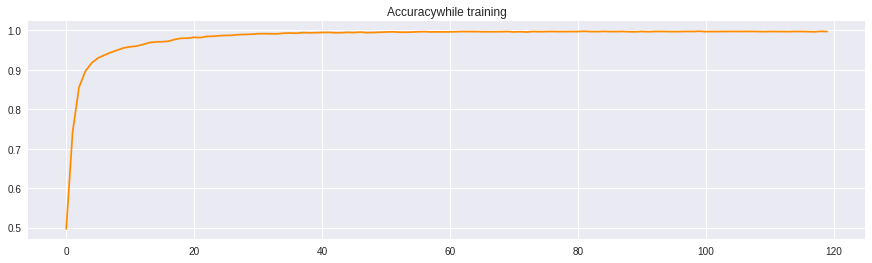

In [161]:
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
figure = plt.figure(figsize=(15, 4))
plt.plot(emotion.history_training.history['accuracy'], 'darkorange', label = 'Accuracy')
plt.title("Accuracywhile training")
plt.show()

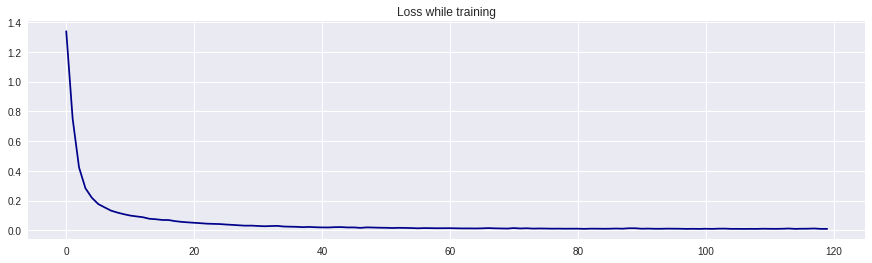

In [164]:
figure = plt.figure(figsize=(15, 4))
plt.plot(emotion.history_training.history['loss'], 'darkblue', label = 'Loss')
plt.title("Loss while training")
plt.show()

In [137]:
emotion.m.evaluate(emotion.X_test, emotion.Y_test, batch_size = 256)

8/8 [==============================] - 0s 15ms/step - loss: 0.3393 - accuracy: 0.9295


[0.33934661746025085, 0.9294999837875366]

In [127]:
y_pred = emotion.m.predict(emotion.X_test)

In [128]:
y_pred = np.argmax(y_pred, axis = 1)

In [129]:
y_pred

array([0, 4, 2, ..., 2, 2, 3])

In [130]:
y_test = np.argmax(emotion.Y_test, axis = 1)

In [131]:
y_test

array([0, 4, 2, ..., 2, 5, 3])

In [132]:
from sklearn.metrics import accuracy_score as acc
print(acc(y_pred, y_test))

0.9295


In [138]:
res = tf.math.confusion_matrix(y_pred,y_test).numpy()

In [139]:
cm = pd.DataFrame(res,
                     index = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'], 
                     columns = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'])
cm

,sadness,anger,love,surprise,fear,joy
sadness,232,11,1,0,4,0
anger,4,237,1,0,6,11
love,1,1,634,25,4,3
surprise,1,0,35,148,0,0
fear,5,10,3,0,549,2
joy,0,7,6,0,0,59


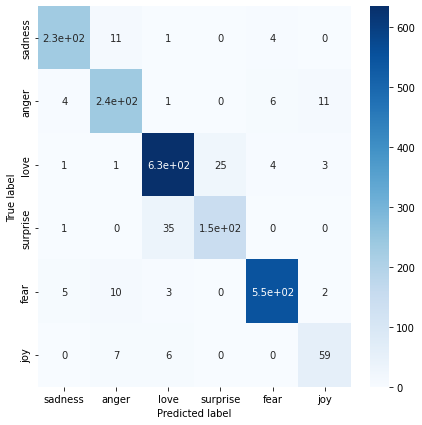

In [148]:
import seaborn as sns
figure = plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [165]:
emotion.m.save("emotion.h5")

#Second Step:
Using the model that has been trained to sort tweets based on sentiment with a rating ratio.

In [168]:
SriLankaTweets = "twitter-dataset-sri-lanka-crisis/SriLankaTweets.csv"

In [169]:
SriLankaTweets = pd.read_csv(SriLankaTweets)

In [170]:
SriLankaTweets.head()

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,0,1546235784730230785,1546089912042127362,1.657486e+12,2022-07-10 20:51:53,0,NaN,@MrJonasDanner Das geht doch seit Beginn der B...,de,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'MrJonasDanner', 'name': 'Jon...",NaN,NaN,NaN,NaN
1,1,1546235779906781186,1546235779906781186,1.657486e+12,2022-07-10 20:51:52,0,NaN,Artículo lúcido y bien informado sobre la cris...,es,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,2,1546235777633468416,1546235777633468416,1.657486e+12,2022-07-10 20:51:51,0,NaN,En argentina y después de lo de Sri Lanka la g...,es,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,3,1546235770582847496,1546185673593524225,1.657486e+12,2022-07-10 20:51:50,0,NaN,@Haqeeqat_TV Ab na daro aur sikho in Sri lank...,hi,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Haqeeqat_TV', 'name': 'Haqee...",NaN,NaN,NaN,NaN
4,4,1546235754342498308,1546235754342498308,1.657486e+12,2022-07-10 20:51:46,0,NaN,Resigned or Arrested? 1. Sri Lanka's presiden...,et,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [171]:
SriLankaTweets.describe()

,Unnamed: 0,id,conversation_id,created_at,timezone,user_id,user_id_str,day,hour,video,...,near,geo,source,user_rt_id,user_rt,retweet_id,retweet_date,translate,trans_src,trans_dest
count,10004.00000,1.000400e+04,1.000400e+04,1.000400e+04,10004.0,1.000400e+04,1.000400e+04,10004.0,10004.000000,10004.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,5001.50000,1.546203e+18,1.545351e+18,1.657478e+12,0.0,7.201205e+17,7.201205e+17,7.0,18.183727,0.158437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2888.05038,1.702829e+13,1.817498e+16,4.059854e+06,0.0,6.565444e+17,6.565444e+17,0.0,1.131568,0.365168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.00000,1.546176e+18,4.317868e+17,1.657472e+12,0.0,7.592490e+05,7.592490e+05,7.0,16.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2500.75000,1.546188e+18,1.546161e+18,1.657475e+12,0.0,5.259509e+08,5.259509e+08,7.0,17.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5001.50000,1.546201e+18,1.546189e+18,1.657478e+12,0.0,9.101587e+17,9.101587e+17,7.0,18.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7502.25000,1.546217e+18,1.546208e+18,1.657482e+12,0.0,1.383220e+18,1.383220e+18,7.0,19.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,10003.00000,1.546236e+18,1.546236e+18,1.657486e+12,0.0,1.546220e+18,1.546220e+18,7.0,20.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
SriLankaTweets['language'].unique()

array(['de', 'es', 'hi', 'et', 'en', 'in', 'fr', 'tr', 'qht', 'it', 'ar',
       'lt', 'und', 'ca', 'tl', 'qme', 'pt', 'ur', 'pl', 'zxx', 'nl',
       'sv', 'bn', 'cs', 'ht', 'ta', 'da', 'qam', 'ro', 'si', 'fi', 'el',
       'sl', 'cy', 'th', 'no', 'mr', 'kn', 'fa', 'ml', 'hu', 'lv', 'am',
       'ru', 'vi', 'ja', 'ne', 'te', 'gu'], dtype=object)

##Dataset pretreatment

In [175]:
SriLankaTweets = SriLankaTweets.loc[SriLankaTweets['language'] == 'en']

In [176]:
len(SriLankaTweets)

5008

In [177]:
SriLankaTweets['tweet'].dropna()

5        Sri Lanka protesters vow to occupy presidentia...
7        @cricketbetting @sampsoncollins @Richard_Mann1...
8        @CeyTamAtheist Worship animals hoping for divi...
10       Yesterday it was Sri Lanka. Today it's Albania...
11       Groundwater shortage is known, flooding too. W...
                               ...                        
9993     @narendramodi ji are you aware of what's happe...
9994     "The United States, together with many other m...
9995     @Swamy39 You never know or get what people are...
9997     Education minister is busy in cutting ribbons ...
10003    Are you going to attack the peaceful protester...
Name: tweet, Length: 5008, dtype: object

In [178]:
def preprocessingText(sentences):
  sentences = sentences.apply(lambda sequence:
                                              [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  return sentences

In [179]:
SriLankaTweets['tweet'] = preprocessingText(SriLankaTweets['tweet'])

In [180]:
SriLankaTweets.head()

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
5,5,1546235750446170113,1546235750446170113,1.657486e+12,2022-07-10 20:51:45,0,NaN,sri lanka protesters vow to occupy presidentia...,en,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
7,7,1546235749594439683,1544613357034110976,1.657486e+12,2022-07-10 20:51:45,0,NaN,cricketbetting sampsoncollins richardmann11 pa...,en,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'cricketbetting', 'name': 'Ed...",NaN,NaN,NaN,NaN
8,8,1546235748357062657,1546029883591106562,1.657486e+12,2022-07-10 20:51:44,0,NaN,ceytamatheist worship animals hoping for divin...,en,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'CeyTamAtheist', 'name': 'Cey...",NaN,NaN,NaN,NaN
10,10,1546235733685555201,1546235733685555201,1.657486e+12,2022-07-10 20:51:41,0,NaN,yesterday it was sri lanka today its albania i...,en,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
11,11,1546235705747202051,1546235705747202051,1.657486e+12,2022-07-10 20:51:34,0,NaN,groundwater shortage is known flooding too we ...,en,"['srilanka', 'baerbock', 'lanz', 'annewill']",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [181]:
features = SriLankaTweets['tweet']

In [182]:
features.head()

5     sri lanka protesters vow to occupy presidentia...
7     cricketbetting sampsoncollins richardmann11 pa...
8     ceytamatheist worship animals hoping for divin...
10    yesterday it was sri lanka today its albania i...
11    groundwater shortage is known flooding too we ...
Name: tweet, dtype: object

In [183]:
len(features)

5008

In [184]:
features.shape

(5008,)

In [204]:
tweets = emotion.tokenizer.texts_to_sequences(features)
tweets = np.array(tweets).reshape(-1)
tweets = pad_sequences(tweets, maxlen= 63)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [205]:
tweets

array([[   0,    0,    0, ...,    4,  315,  185],
       [   0,    0,    0, ...,  932,   11,    5],
       [   0,    0,    0, ..., 1306,    4, 1097],
       ...,
       [   0,    0,    0, ...,   95,  134,   32],
       [   0,    0,    0, ..., 1748,   21,   22],
       [   0,    0,    0, ...,    5,  638,  127]], dtype=int32)

In [206]:
tweets.shape

(5008, 63)

##Using the sentiment analysis model:
Using the trained sentiment analysis model, in order to analyze the sentiments of tweeters within the Sri Lanka dataset.
Sentiment type and sentiment affiliation will be preserved for each Tweet.

In [241]:
sentiment_labels = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']
sentiment_labels_encoding = [0, 1, 2, 3, 4, 5]

In [222]:
results_sen_tweets = emotion.m.predict(tweets, batch_size = 256)

In [267]:
sentiments = []
for i in results_sen_tweets:
  res = np.argmax(i, axis = 0)
  sentiments.append([sentiment_labels_encoding[res], i[res]])

In [268]:
len(sentiments)

5008

In [269]:
sentiments[:10]

[[2, 0.38308504],
 [4, 0.9982109],
 [2, 0.9998367],
 [1, 0.9885429],
 [4, 0.6438615],
 [0, 0.46688205],
 [0, 0.65498286],
 [4, 0.6473544],
 [0, 0.91321164],
 [0, 0.7946743]]

##A graph showing the distribution of tweeters' feelings regarding events in Sri Lanka

In [301]:
def count_sent(sentiments, depending_on):
  c = 0
  for i in sentiments:
    if i[0] == depending_on:
      c = c + 1
  return c    

In [302]:
arr = []
for i in sentiment_labels_encoding:
  arr.append(count_sent(sentiments, i))

In [303]:
arr

[1467, 592, 1628, 79, 1080, 162]

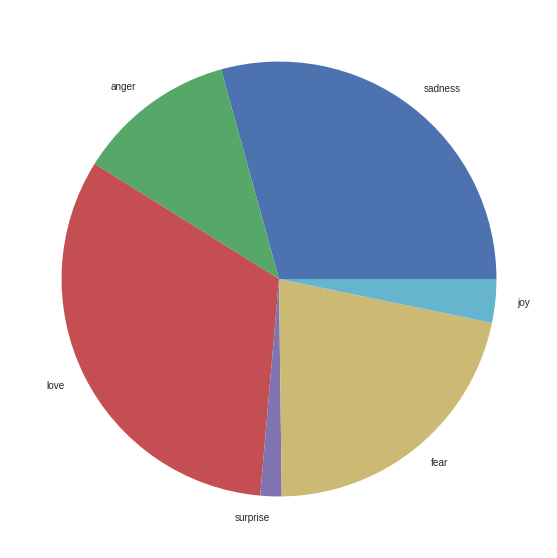

In [306]:
plt.pie(arr, labels = sentiment_labels)
plt.show()

##The hierarchical distribution of each feeling:
This stage aims to determine the degree of convergence in terms of the single feeling of the tweeters, depending on the aggregation process based on the Euclidean distance, which depends on the percentage of feeling classification.

###Dendrogram for Each Sentiment

In [328]:
def each_sent(sentiments, depending_on):
  arr = []
  for i in sentiments:
    if i[0] == depending_on:
      arr.append(i)
  return arr   

In [329]:
arr = []
for i in sentiment_labels_encoding:
  arr.append(each_sent(sentiments, i))

In [336]:
import scipy.cluster.hierarchy as shc
def draw_dendrogram(sentiments, title):
  plt.figure(figsize=(15, 15))
  plt.title(title)
  clusters = shc.linkage(sentiments, 
              method='ward', 
              metric="euclidean")
  shc.dendrogram(Z=clusters)
  plt.show()

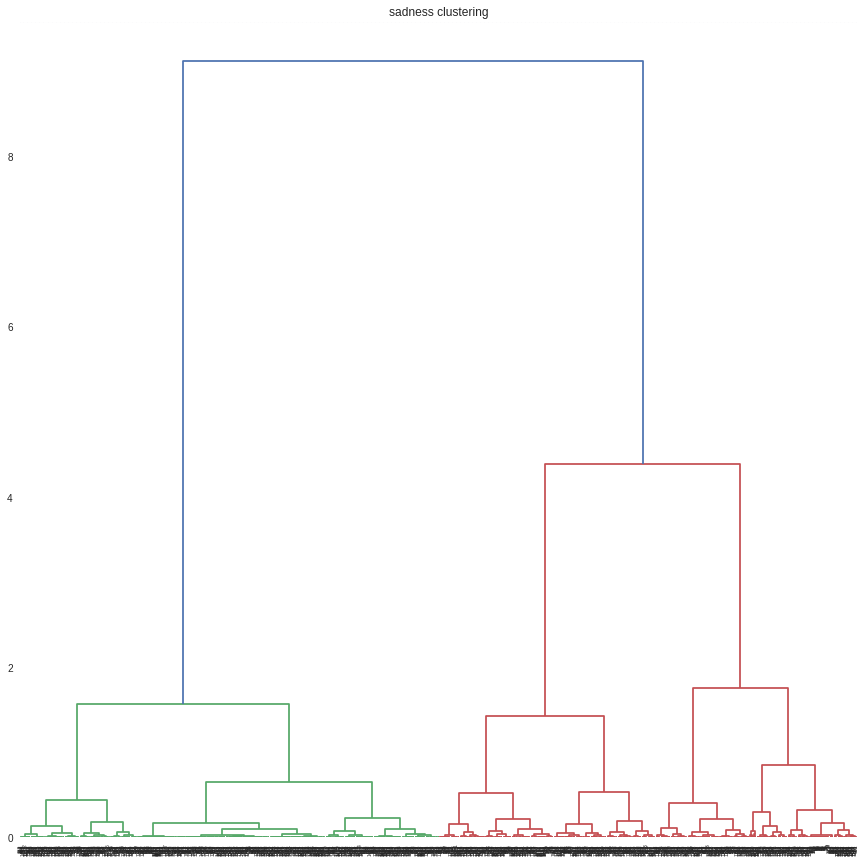

In [337]:
draw_dendrogram(arr[0], 'sadness clustering')

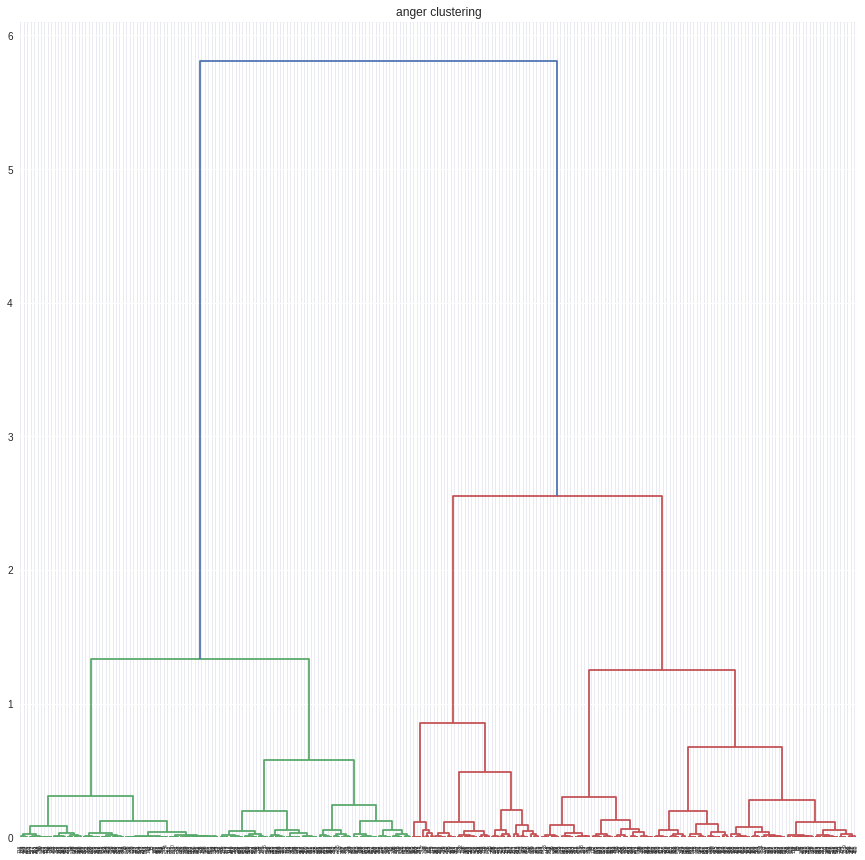

In [338]:
draw_dendrogram(arr[1], 'anger clustering')

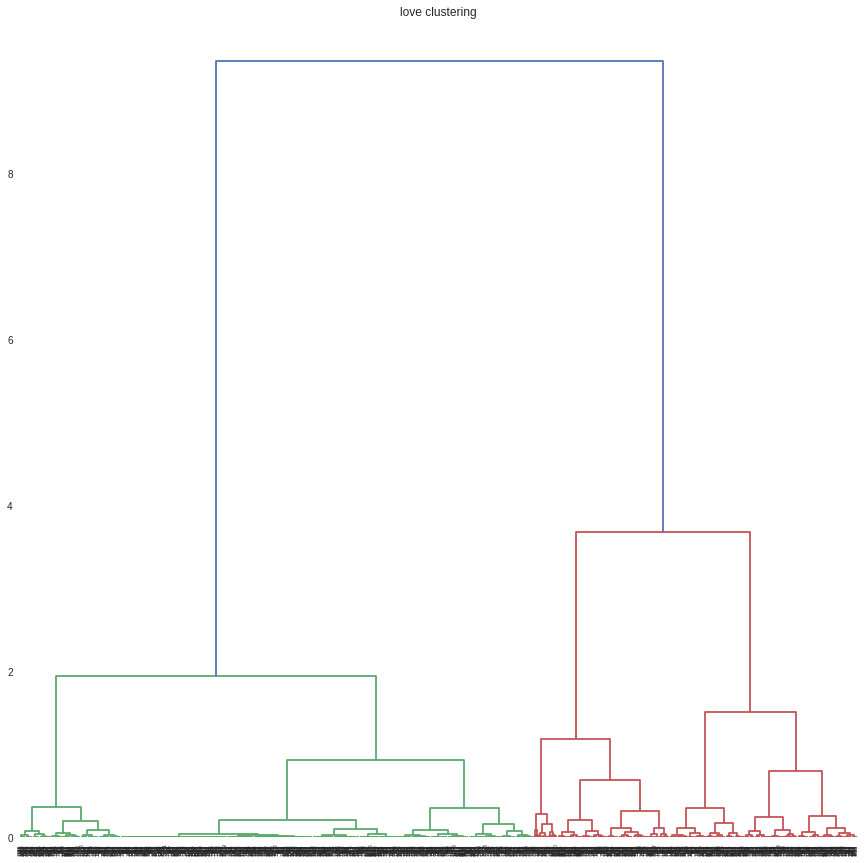

In [339]:
draw_dendrogram(arr[2], 'love clustering')

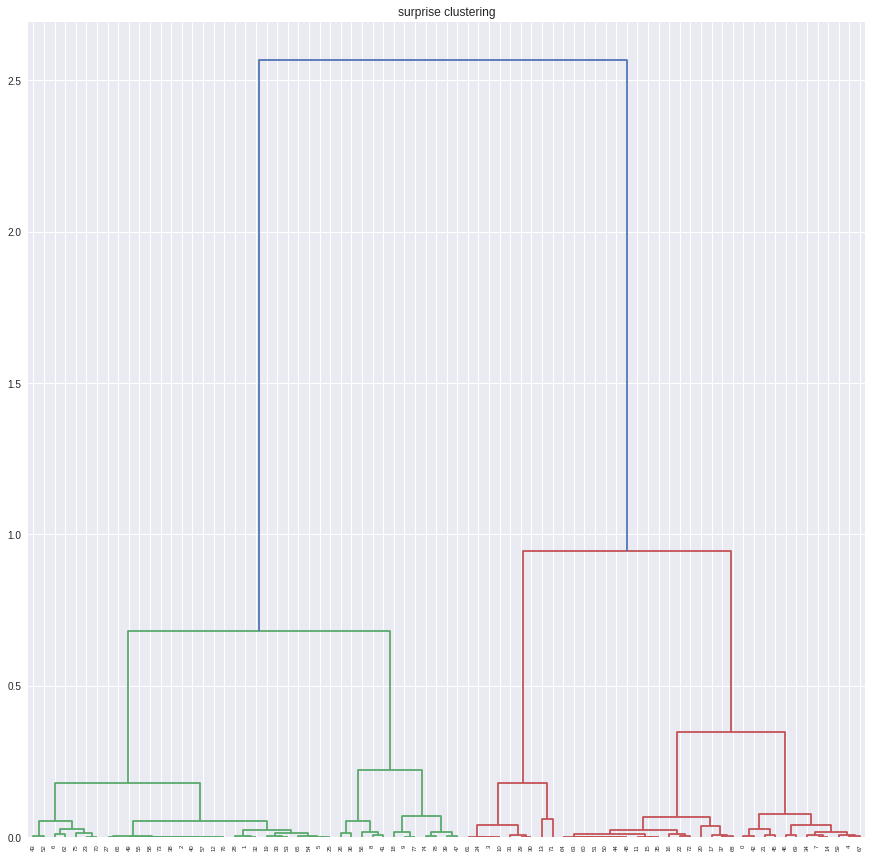

In [340]:
draw_dendrogram(arr[3], 'surprise clustering')

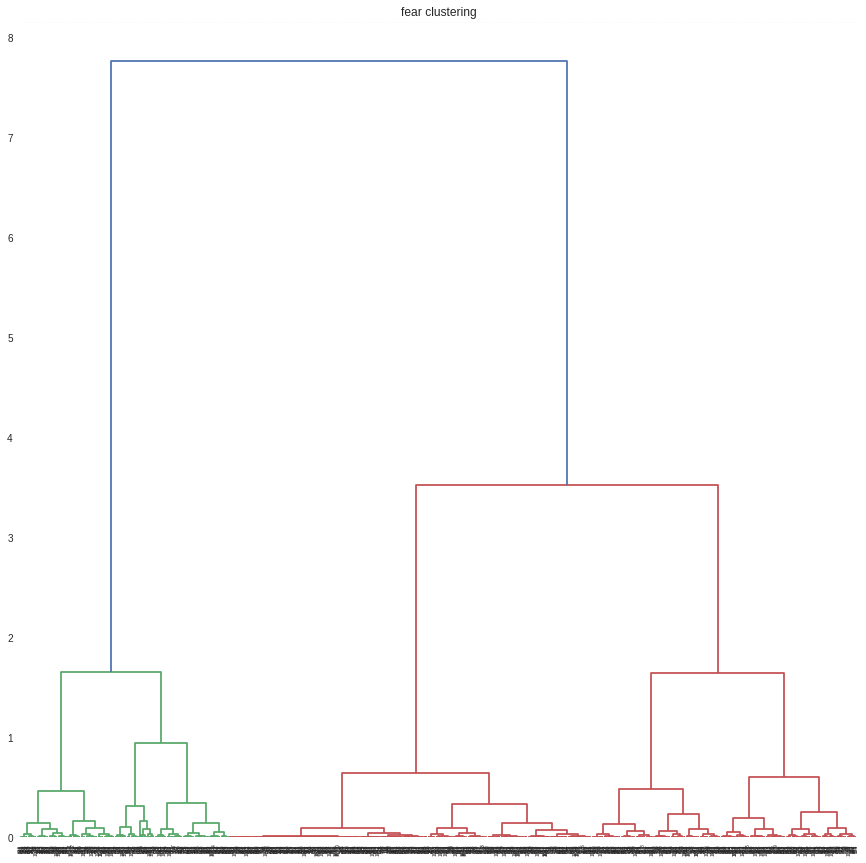

In [341]:
draw_dendrogram(arr[4], 'fear clustering')

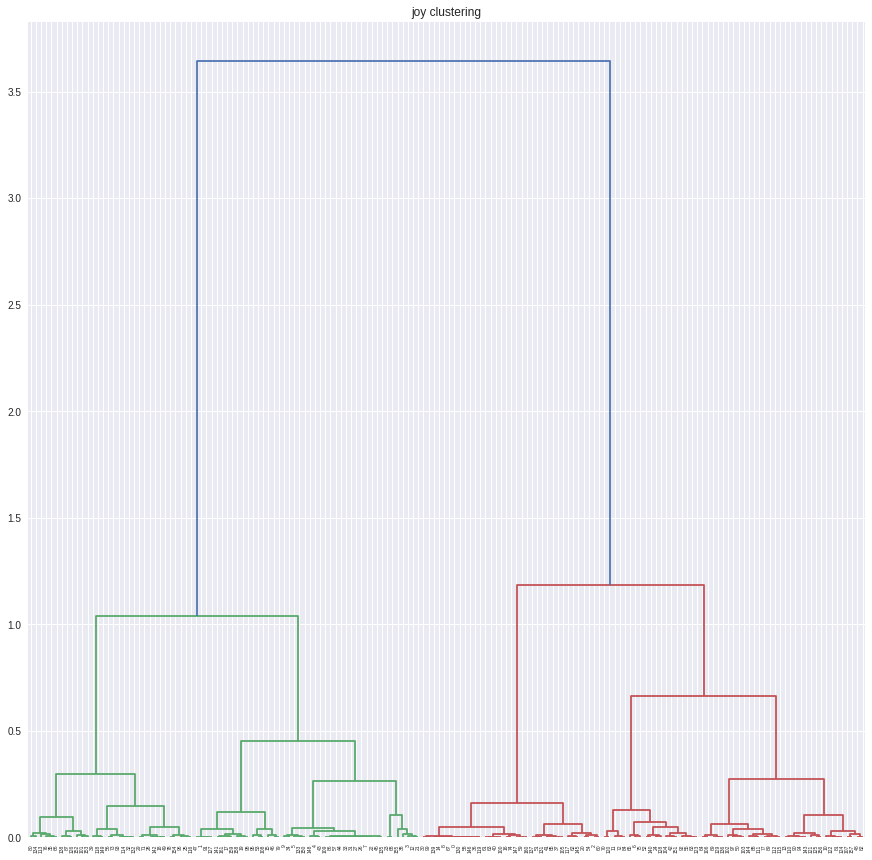

In [342]:
draw_dendrogram(arr[5], 'joy clustering')